## Predicting income bracket
Here I build a quick model to determine income bracket- the income levels are binned at below 50k and above 50k.  

Some of the features are:

Age  
Marital Status  
Income  
Family Members  
No. of Dependents  
Tax Paid  
Investment (Mutual Fund, Stock)  
Return from Investments  
Education  
Spouse Education  
Nationality  
Occupation  
Region in US  
Race  
Occupation category  

In [76]:
from collections import defaultdict
from operator import itemgetter
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.model.metrics_base import H2OBinomialModelMetrics
import h2o
import os
import sys
sys.path.append('../MLRecipes')

# machine learning helper code
import ml_helper as mlhelp 

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)

Python version: 3.5.2
numpy version: 1.11.1
pandas version: 0.18.1
scikit-learn version: 0.18.1


In [2]:
# Preprocessing functions
def label_map(y):    
    """Encodes labels"""
    
    # For incomes above 50k
    if y == 50000:
        return 1
    elif y == '50000+.':
        return 1
    elif y == ' 50000+.':
        return 1
    
    # For incomes below 50k
    elif y == -50000:
        return 0
    elif y == '-50000':
        return 0

def isNan(num):
    """Test for Nan"""
    return num != num

def add_MDcol(df, col_list):
    """Add column for missing categorical data"""
    for col in col_list:
        df[col+'_missing'] = df[col].apply(isNan)

#### Data preprocessing

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,-50000
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,-50000
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,-50000
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000


In [4]:
train.shape

(199523, 41)

In [5]:
test.shape

(99762, 41)

The train data has 199,523 rows and 41 columns. The test data has 99,762 rows and 41 columns.

#### Cleanup
Let's look at the labels:

In [6]:
train.income_level.value_counts()

-50000    187141
 50000     12382
Name: income_level, dtype: int64

In [7]:
test.income_level.value_counts()

-50000      93576
 50000+.     6186
Name: income_level, dtype: int64

Note: We have imbalanced classes here. The higher income class is about 6% of the total. 

The labels are not written the same way. I'll encode these variables as 0 and 1:

In [8]:
test['income_level'] = test['income_level'].apply(label_map)
train['income_level'] = train['income_level'].apply(label_map)

In [11]:
# Going to combine train and test from this dataset for now
alldata = train.append(test)

In [48]:
alldata.income_level.value_counts()

0    280717
1     18568
Name: income_level, dtype: int64

#### Check for missing values

In [12]:
alldata.isnull().values.any()

True

There are some missing values.

In [13]:
alldata.isnull().sum()

age                                     0
class_of_worker                         0
industry_code                           0
occupation_code                         0
education                               0
wage_per_hour                           0
enrolled_in_edu_inst_lastwk             0
marital_status                          0
major_industry_code                     0
major_occupation_code                   0
race                                    0
hispanic_origin                       874
sex                                     0
member_of_labor_union                   0
reason_for_unemployment                 0
full_parttime_employment_stat           0
capital_gains                           0
capital_losses                          0
dividend_from_Stocks                    0
tax_filer_status                        0
region_of_previous_residence            0
state_of_previous_residence           708
d_household_family_stat                 0
d_household_summary               

All the missing values are part of categorical features. I'll fill in the nans with "missing"- then when I do one-hot encoding this will essentially create an extra "missing" category.

Note: For H2O model implementations, we don't have to fill in these nans, but we do for sklearn's.

In [14]:
# Have to fill in nans for sklearn implementations
alldata_nonan = alldata.fillna(value='missing')

#### Explore data

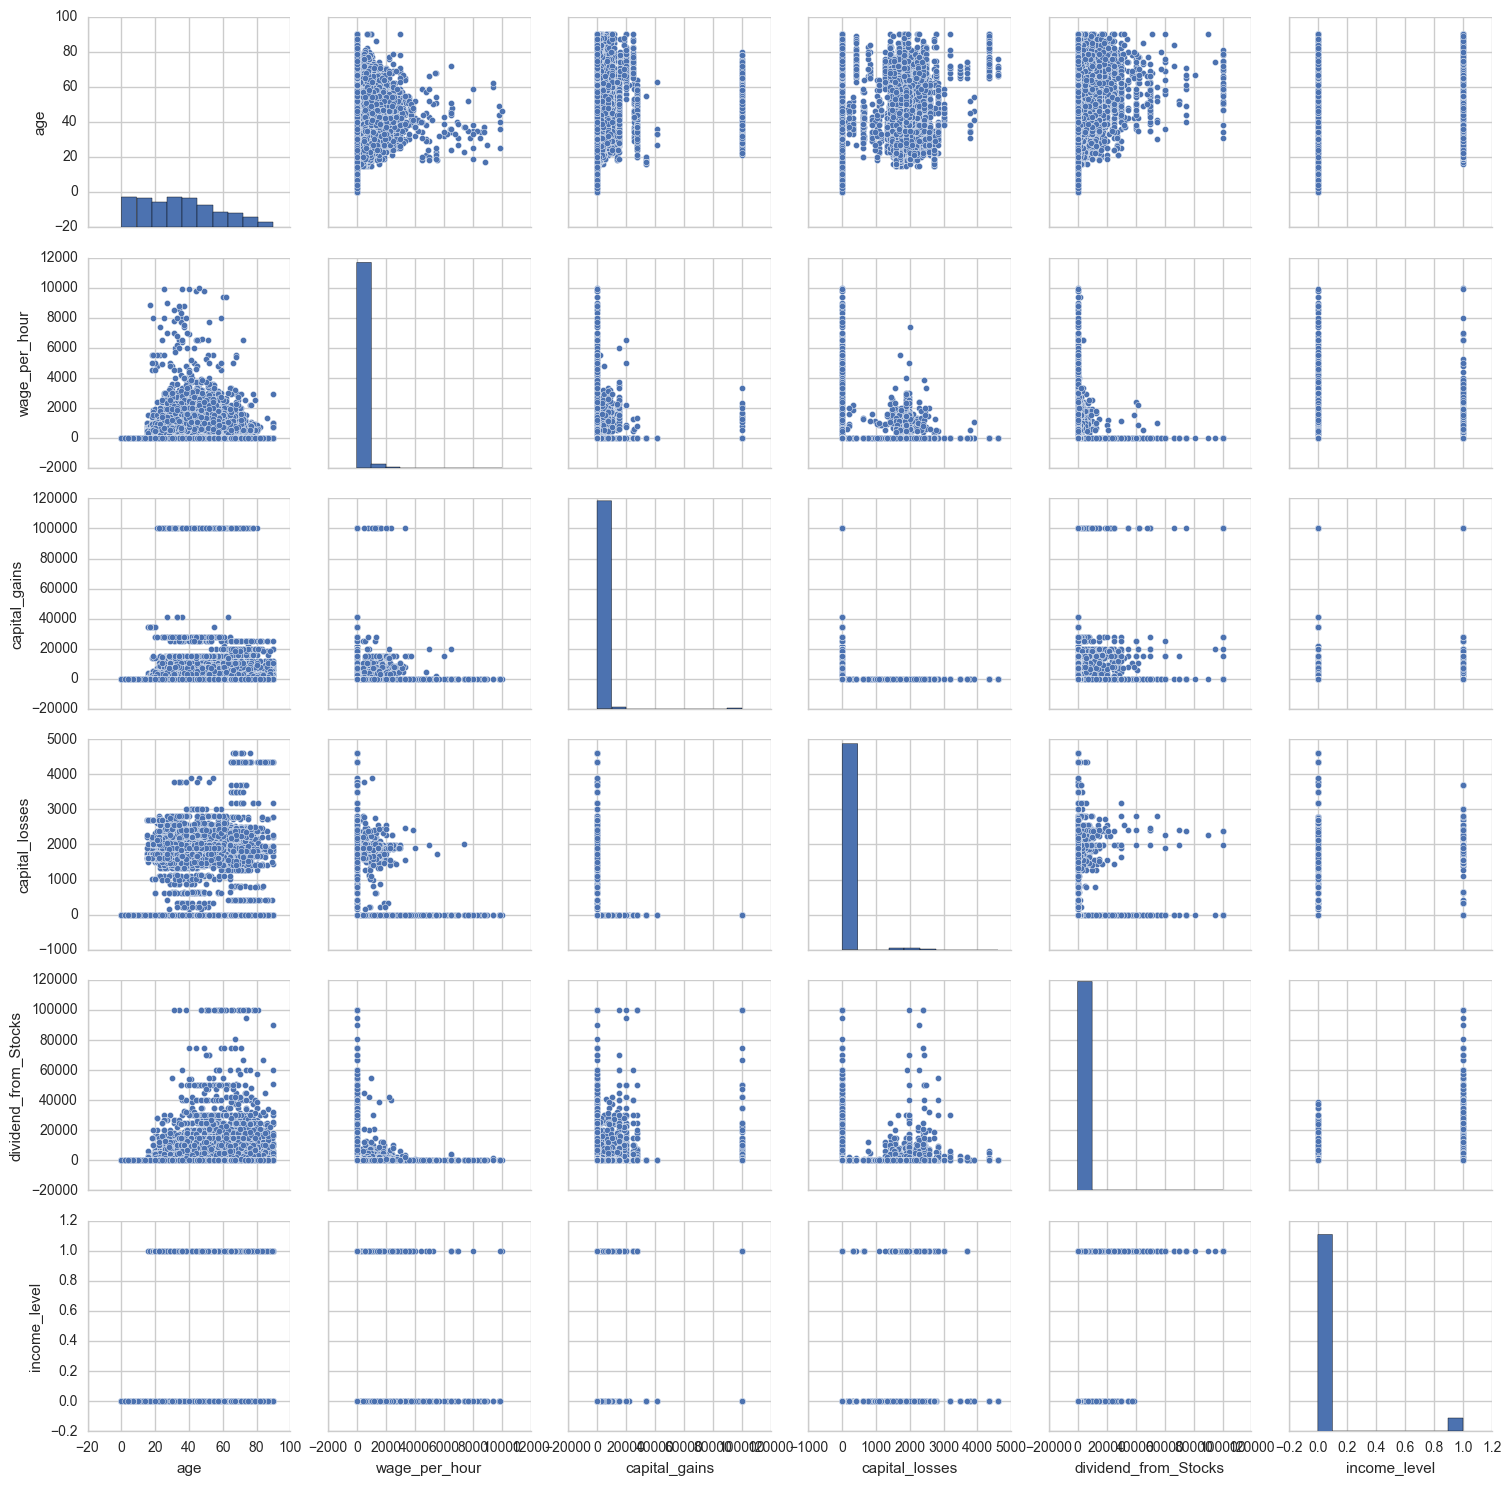

In [67]:
sns.set(style='whitegrid',context='notebook')
cols=['age','wage_per_hour', 'capital_gains','capital_losses','dividend_from_Stocks' ,'d_household_family_stat','income_level']
sns.pairplot(alldata_nonan[cols],size=2.5)
plt.show()

The lower income bracket has lower dividend_from_stocks. Unsurprisingly, none of the youngest people (under age 20) were in the higher income bracket. Interestingly wage_per_hour is not necessarily higher for the higher income bracket. 

#### Quick random forest model
I'll do a quick model for now before doing any feature engineering, etc.

In [23]:
col_list = list(alldata_nonan)
features = mlhelp.make_normal_features(alldata_nonan, col_list)

column_to_predict = 'income_level'

# Prepare data to be used in the model by transforming 
# the lists of feature-value dictionaries to vectors
# When feature values are strings, the DictVectorizer will do a binary one-hot coding
X, y, dv, mabs = mlhelp.create_data_for_model(alldata_nonan, features, column_to_predict)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, 
                                                      stratify=y, random_state=2016)

In [24]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

y_predict = rf.predict(X_test)
mlhelp.classification_accuracy(y_truth=y_test, y_predict=y_predict);

Percentage correct predictions = 99.37
Percentage correct predictions (true class 0) = 99.99
Percentage correct predictions (true class 1) = 89.93


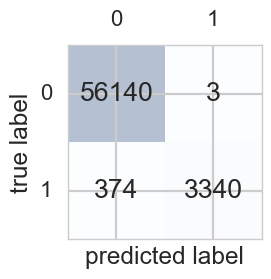

In [25]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_predict)

fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

The classifier does a bit worse with class 1 (the rare class).    
Some important features:

In [33]:
mlhelp.print_features_importances(rf, dv, max_print=10)

income_level 0.322192086021
num_person_Worked_employer 0.063498787871
occupation_code 0.0590363279715
weeks_worked_in_year 0.0523350224565
dividend_from_Stocks 0.0484704052559
age 0.0371623762101
industry_code 0.024954228483
major_occupation_code=Not in universe 0.022879498577
capital_gains 0.019464985337
family_members_under_18=Not in universe 0.0193774196446
tax_filer_status=Joint both under 65 0.0157218318548


#### Random forest (H2O)

The H2O implementation lets you work with categorical variables well (without one-hot encoding). You can also feed in missing values.

In [35]:
h2o.init(max_mem_size = "2G", nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_40"; Java(TM) SE Runtime Environment (build 1.8.0_40-b27); Java HotSpot(TM) 64-Bit Server VM (build 25.40-b25, mixed mode)
  Starting server from /Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5d/ftxntrp16l5g04c049nr03pr0000gp/T/tmp8unwahts
  JVM stdout: /var/folders/5d/ftxntrp16l5g04c049nr03pr0000gp/T/tmp8unwahts/h2o_jkim_started_from_python.out
  JVM stderr: /var/folders/5d/ftxntrp16l5g04c049nr03pr0000gp/T/tmp8unwahts/h2o_jkim_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,2 months and 23 days
H2O cluster name:,H2O_from_python_jkim_au9j72
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [36]:
h2ofr = h2o.H2OFrame(alldata)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [37]:
h2ofr['income_level'] = h2ofr['income_level'].asfactor()

In [38]:
splits = h2ofr.split_frame(ratios=[0.7, 0.15], seed=1)
train = splits[0]
valid = splits[1]
test = splits[2]

In [39]:
y = 'income_level'
x = list(h2ofr.columns)

x.remove(y) # remove response variable

In [40]:
RF = H2ORandomForestEstimator(balance_classes=True)
RF.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [41]:
RF_perf = RF.model_performance(test)
print(RF_perf)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.03933510927017885
RMSE: 0.1983308076678428
LogLoss: 0.13454365044271357
Mean Per-Class Error: 0.12912999956069804
AUC: 0.9419047339083383
Gini: 0.8838094678166766
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15341475654483194: 


,0,1,Error,Rate
0,40413.0,1655.0,0.0393,(1655.0/42068.0)
1,1056.0,1695.0,0.3839,(1056.0/2751.0)
Total,41469.0,3350.0,0.0605,(2711.0/44819.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1534148,0.5556466,238.0
max f2,0.0605274,0.6452438,309.0
max f0point5,0.2931981,0.5944438,167.0
max accuracy,0.3146628,0.9514938,158.0
max precision,0.9678719,1.0,0.0
max recall,0.0000013,1.0,399.0
max specificity,0.9678719,1.0,0.0
max absolute_mcc,0.1534148,0.5264549,238.0
max min_per_class_accuracy,0.0423279,0.8665256,327.0
max mean_per_class_accuracy,0.0340331,0.8708700,337.0


Gains/Lift Table: Avg response rate:  6.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100181,0.5807658,13.3165368,13.3165368,0.8173719,0.8173719,0.1334060,0.1334060,1231.6536850,1231.6536850
,2,0.0200138,0.4275829,11.6007012,12.4595755,0.7120536,0.7647715,0.1159578,0.2493639,1060.0701206,1145.9575458
,3,0.0300096,0.3336476,9.8551411,11.5920761,0.6049107,0.7115242,0.0985096,0.3478735,885.5141150,1059.2076149
,4,0.0400054,0.2664508,7.4913619,10.5674694,0.4598214,0.6486336,0.0748819,0.4227554,649.1361907,956.7469356
,5,0.0500011,0.2225875,6.2185577,9.6980751,0.3816964,0.5952700,0.0621592,0.4849146,521.8557700,869.8075147
,6,0.1000022,0.1039517,4.5073513,7.1027132,0.2766622,0.4359661,0.2253726,0.7102872,350.7351268,610.2713208
,7,0.1500033,0.0577457,2.3990741,5.5348335,0.1472557,0.3397293,0.1199564,0.8302435,139.9074062,453.4833492
,8,0.2000045,0.0334897,1.3013159,4.4764541,0.0798751,0.2747657,0.0650672,0.8953108,30.1315931,347.6454102
,9,0.3000067,0.0143031,0.5743238,3.1757440,0.0352521,0.1949279,0.0574337,0.9527445,-42.5676209,217.5743998
,10,0.4000089,0.0064538,0.2944318,2.4554160,0.0180723,0.1507140,0.0294438,0.9821883,-70.5568183,145.5415953


This one actually performs worse in predicting class 1 compared to the sklearn implementation. It only gets about 62% of class 1 right compared to getting 96% of class 0 right.